In [1]:

from sentence_to_predicate import WordPredicate
import json
import sentence_grounding_test_parameters as param
import numpy as np
from recognized_object import RecognizedObject

from plots import *
from data_processing import *

import sys
import time
import matplotlib.pyplot as plt
import math
import os

from reservoirpy import ESNOnline, mat_gen, ESN
from reservoirpy.mat_gen import generate_internal_weights, generate_input_weights
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'



In [2]:
import tensorflow.keras

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Masking, GRU
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import BertModel, BertTokenizer
from transformers import pipeline

/home/subbainria/anaconda3/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [3]:
def test_with_sentences_ESN(sentences, model, nb_concepts, threshold_factor):
    
    test = []
    for s in sentences:
        #print(s)
        temp = []
        for w in s.split():
            temp.append(nlp(w))
        temp = np.array(temp)
        #print(temp.shape)
        temp = np.reshape(temp,(temp.shape[0], temp.shape[2], temp.shape[3]))
        temp = np.mean(temp, axis=1)
        #print(np.mean(temp, axis=1).shape)
        #print(temp.shape)
        test.append(temp)
    """
    test = [one_hot_encoding_sentence(s) for s in sentences]
    """
    res = []
    model.reset_reservoir()
    for i in range(len(sentences)):
        outputs, int_states = model.run([test[i],])
        res.append(outputs[0])
        model.reset_reservoir()
    return res, [output_to_vision(res[j][-1],nb_concepts, threshold_factor, concepts_delimitations, output_id_to_concept_dict) for j in range(len(res))]

In [4]:
def test_with_sentences_ESN(sentences, model, nb_concepts, threshold_factor):
    test = []
    test = []
    for s in sentences:
        #print(s)
        temp = []
        for w in s.split():
            temp.append(np.mean(np.array(nlp(w)),axis=1))
        #temp = np.array(nlp(s))
        #print(temp.shape)
        temp = np.array(temp)
        temp = np.reshape(temp,(temp.shape[0]*temp.shape[1], temp.shape[2]))
        #temp = np.mean(temp, axis=1)
        #print(np.mean(temp, axis=1).shape)
        #print(temp.shape)
        test.append(temp)
    res = []
    model.reset_reservoir()
    for i in range(len(sentences)):
        outputs, int_states = model.run([test[i],])
        res.append(outputs[0])
        model.reset_reservoir()
    return res, [output_to_vision(res[j][-1],nb_concepts, threshold_factor, concepts_delimitations, output_id_to_concept_dict) for j in range(len(res))]

In [5]:
def test_with_sentences(sentences, model):
    global max_seq_len
    test = []
    
    for s in sentences:
        #print(s)
        temp = []
        for w in s.split():
            temp.append(nlp(w))
        temp = np.array(temp)
        #print(temp.shape)
        temp = np.reshape(temp,(temp.shape[0], temp.shape[2], temp.shape[3]))
        temp = np.mean(temp, axis=1)
        #print(np.mean(temp, axis=1).shape)
        #print(temp.shape)
        test.append(temp)
    test = []
    """
    for s in sentences:
        #print(s)
        temp = []
        #for w in s.split():
        #    temp.append(np.mean(np.array(nlp(w)),axis=1))
        temp = np.array(nlp(s))
        #print(temp.shape)
        temp = np.reshape(temp,(temp.shape[0]*temp.shape[1], temp.shape[2]))
        #temp = np.mean(temp, axis=1)
        #print(np.mean(temp, axis=1).shape)
        #print(temp.shape)
        test.append(temp)
    """
    #test = [one_hot_encoding_sentence(s) for s in sentences]
    test_pad = padding(test, max_seq_len)
    res = model.predict(test_pad)
    return res

In [6]:
def test_on_test_set(model, test_sentences, testX, testY, verbose, threshold_factor, online):

    test_outputs = []
    rmse = 0
    for sent_nb in range(len(testX)):
        if online:
            model.reset_reservoir()
        outputs, int_states = model.run([testX[sent_nb],])
        test_outputs.append(outputs[0][-1])
        rmse += np.mean( (outputs[0][-1] - testY[sent_nb])**2)
    rmse = np.sqrt(rmse/len(testX))

    if verbose:
        print("End of testing")
    exact = 0
    valid = 0
    for i in range(len(test_outputs)):
        v = output_to_vision(test_outputs[i],nb_concepts, threshold_factor, concepts_delimitations, output_id_to_concept_dict)
        pred = sentence_to_pred(test_sentences[i], sent_to_role)


        if is_an_exact_representation(pred, v):
            exact +=1

        if is_a_valid_representation(pred, v):
            valid +=1

        if is_a_valid_representation(pred, v) and not(is_an_exact_representation(pred, v)):
            pass

    nb_sample = len(testX)
    if verbose:
        print("Valid representations : ", valid,"/", nb_sample)
        print("Exact representations : ", exact, "/", nb_sample)
    return 1-valid/nb_sample, 1-exact/nb_sample, rmse

In [7]:
## to get the evolution of the loss during training
class LossHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.exact_errors = []
        self.valid_errors = []

    def on_epoch_end(self, epoch, logs=None):
        global validationX_pad
        global validationY
        self.losses.append(logs.get('loss'))

        v, ex, er = test_on_test_set(self.model, validationX_pad, validationY, validation_sentences, True, 1.3)

        self.val_losses.append(er)
        self.exact_errors.append(ex)
        self.valid_errors.append(v)

    def plot_loss(self):
        plt.figure()
        plt.plot(self.losses, color = "black", label = "loss")
        plt.plot(self.val_losses, color = "red", label = "loss on validation set")
        plt.xlabel("epochs of training")
        plt.title("MSE during training")
        plt.legend()
        plt.show()
        plt.figure()
        plt.title("Performance on validation set during training")
        plt.plot(self.exact_errors, color = "blue", label = "exact error")
        plt.plot(self.valid_errors, color = "green", label = "valid error")
        plt.legend()
        plt.show()

In [8]:
## functions used to create RSSviz showing the position of the errors
def getErrorScore(pred, obj):
    if is_an_exact_imagined_object(pred, obj):
        return 2
    elif is_a_valid_imagined_object(pred, obj):
        return 1
    else:
        return 0

def errorCode(obj_er):
    return (obj_er[0] + 3*obj_er[1])


def getErrorsInfo(reservoir_state, sentences, Wout, threshold_fact = 1.3):
    global nb_concepts, sent_to_role
    errors = []
    ind = 0
    for s in sentences:
        pred = sentence_to_pred(s, sent_to_role)
        for i in range(len(s.split(" "))):
            output = np.dot(Wout, reservoir_state[ind])
            v = output_to_vision(output,nb_concepts, threshold_fact,
                                 concepts_delimitations, output_id_to_concept_dict)
            obj_errors = (getErrorScore(pred[0], v[0]), getErrorScore(pred[1], v[1]))
            errors.append(errorCode(obj_errors))
            ind +=1
    return np.array(errors)

In [9]:
def get_int_states(model, sentences, one_chunck = True, only_last = False, get_obj_nb = False):

    #test = [one_hot_encoding_sentence(s) for s in sentences]
    test = []
    for s in sentences:
        #print(s)
        temp = []
        for w in s.split():
            temp.append(nlp(w))
        temp = np.array(temp)
        #print(temp.shape)
        temp = np.reshape(temp,(temp.shape[0], temp.shape[2], temp.shape[3]))
        temp = np.mean(temp, axis=1)
        #print(np.mean(temp, axis=1).shape)
        #print(temp.shape)
        test.append(temp)
    int_states_on_sent = []
    labels = []

    clause_nb = []

    for i in range(len(sentences)):
        model.reset_reservoir()
        outputs, int_states = model.run([test[i],])

        if only_last:
            int_states_on_sent.append(int_states[0][-1].reshape((int_states[0][-1].shape[0])))
        else:
            if one_chunck:
                for k in range(int_states[0].shape[0]):
                    int_states_on_sent.append(int_states[0][k].reshape((int_states[0][k].shape[0])))
            else:
                int_states_on_sent.append(int_states[0].reshape((int_states[0].shape[0], int_states[0].shape[1])))

            if get_obj_nb:
                words = sentences[i].split(" ")
                clause_id = 0
                for w in range(len(words)):
                    if words[w] == "and":
                        clause_id +=1
                    clause_nb.append(clause_id)
                    if words[w] == "and":
                        clause_id +=1
                clause_nb[-1] = 3 #final states

        words = sentences[i].split(" ")
        for j in range(1, len(words)+1):
            labels.append(" ".join(words[:j]))

    if one_chunck:
        int_states_on_sent = np.array(int_states_on_sent)

    if get_obj_nb:
        return int_states_on_sent, labels, np.array(clause_nb)
    else:
        return int_states_on_sent, labels

In [10]:
def plot_hidden_states(sentence, model_for_test, state = 'cell', units_to_plot = 'all', plt_var = False, plt_sum = False):
    activations = get_successive_outputs(sentence, model_for_test)

    plot_hidden_state_activation(sentence,
                                 activations,
                                 state,
                                 units_to_plot,
                                 plot_variation = plt_var,
                                 plot_sum = plt_sum)

In [11]:
################### MAIN #####################

## Parameters


add_begin_end = True #add the word "BEGIN" at the beggining and "END" at the end of all sentences ?
verbose_training = True
continuous_sentence_training = True # continuous or final training


use_save = False # use saved matrices from previous run ?
if use_save:
    name_id = '0.8885270787313605' #example random id of the files to load
    pth = r"saved_ESN/" #path to the saved arrays

threshold_factor = 1.3 # the factor used to get the threshold in the creation of he discrete representation
nb_objects = 4 #number of objects in the vocabulary used to generate the sentences (the bigger the harder)
N = 1000 #the size of the reservoir


#this code can be used in command line to specify the number of object and easily test different number of objects

minimal_mode = False #if minimal mode is on, the ESN will only be trained and tested on test set. The only text print will be "nb of objects, valid error on test set, exact error on test set, RMSE on test set, time to train"

In [12]:
##dataset initialisation : creation of the sentence according to the grammar

param.create_dataset(nb_objects = nb_objects)

#one hot encoding initialisation
sent_to_role= param.SENTENCE_TO_ROLES


other_words = ['and']
if add_begin_end:
    other_words.append("BEGIN")
    other_words.append("END")

init_one_hot_encoding(list(sent_to_role.keys()) + other_words)
nb_unique_words = len(word2one_hot_id)


In [13]:
#concept dictionnary initialisation (it's the link between the output position and their meaning)
concepts = param.CATEGORIES + param.POSITIONS + param.COLORS

concepts_delimitations = [(0,len(param.CATEGORIES)),
                          (len(param.CATEGORIES),
                          len(param.CATEGORIES) + len(param.POSITIONS)),
                          (len(param.CATEGORIES) + len(param.POSITIONS),
                          len(param.CATEGORIES) + len(param.POSITIONS)+ len(param.COLORS))]

nb_concepts = len(concepts)

output_size = 2*nb_concepts

concept_to_output_id_dict = {}
output_id_to_concept_dict = {}
for i,c in enumerate(concepts):
    concept_to_output_id_dict[c] = i
    output_id_to_concept_dict[i] = c

In [14]:
##generate data

sentences_one_object = list(sent_to_role.keys())
sentences_two_objects = []

for s1 in sentences_one_object:
    for s2 in sentences_one_object:
        sentences_two_objects.append(s1 + " and " + s2)

#we adjust the different dictionnaries to include sentences with BEGIN and END

if add_begin_end:
    for i in range(len(sentences_one_object)):

        sent_to_role["BEGIN "+ sentences_one_object[i]+ " END"] = [0] + sent_to_role[sentences_one_object[i]] + [0]
        sent_to_role["BEGIN "+ sentences_one_object[i]] = [0] + sent_to_role[sentences_one_object[i]]
        sent_to_role[ sentences_one_object[i] + " END"] = sent_to_role[sentences_one_object[i]] + [0]
        sentences_one_object[i] = "BEGIN "+ sentences_one_object[i]+ " END"

    for i in range(len(sentences_two_objects)):
        sentences_two_objects[i] = "BEGIN "+ sentences_two_objects[i]+ " END"

In [15]:
#create the training, test and validation set

np.random.shuffle(sentences_one_object)
np.random.shuffle(sentences_two_objects)

train_one_obj = 300
train_two_objs = 700


test_one_obj = 300
test_two_objs = 700


In [16]:
train_sentences = (sentences_one_object[:train_one_obj]
              + sentences_two_objects[:train_two_objs])


test_sentences = (sentences_one_object[-test_one_obj:]
              + sentences_two_objects[-test_two_objs:])

In [ ]:
do_lower_case = True
model = BertModel.from_pretrained("anonymous/BERT-NLP", output_attentions=True)
tokenizer = BertTokenizer.from_pretrained("anonymous/BERT-NLP", do_lower_case=do_lower_case)

nlp = pipeline('feature-extraction',model=model, tokenizer=tokenizer)

In [18]:
trainX = []
for s in train_sentences:
    temp = []
    for w in s.split():
        temp.append(nlp(w))
        #print(np.array(nlp(w)).shape)
        #temp.append(np.mean(np.array(nlp(w)),axis=1))
    temp = np.array(temp)
    temp = np.reshape(temp,(temp.shape[0], temp.shape[2], temp.shape[3]))
    temp = np.mean(temp, axis=1)
    #print(np.mean(temp, axis=1).shape)
    #print(temp.shape)
    trainX.append(temp)

In [19]:
testX = []
for s in test_sentences:
    temp = []
    for w in s.split():
        temp.append(nlp(w))
        #temp.append(np.mean(np.array(nlp(w)),axis=1))
    temp = np.array(temp)
    temp = np.reshape(temp,(temp.shape[0],temp.shape[2], temp.shape[3]))
    temp = np.mean(temp, axis=1)
    #print(np.mean(temp, axis=1).shape)
    #print(temp.shape)
    testX.append(temp)

In [41]:
trainX = []
for s in train_sentences:
    temp = []
    #for w in s.split():
    #    temp.append(np.mean(np.array(nlp(w)),axis=1))
        #print(np.array(nlp(w)).shape)
        #temp = np.array(temp)
    #print(np.array(nlp(s)).shape)
    temp = np.array(nlp(s))
    #print(temp.shape)
    temp = np.reshape(temp,(temp.shape[0]*temp.shape[1], temp.shape[2]))
    #temp = np.mean(temp, axis=1)
    #print(np.mean(temp, axis=1).shape)
    #print(temp.shape)
    trainX.append(temp)

In [42]:
testX = []
for s in test_sentences:
    temp = []
    #for w in s.split():
    #    temp.append(np.mean(np.array(nlp(w)),axis=1))
    temp = np.array(nlp(s))
    temp = np.reshape(temp,(temp.shape[0]*temp.shape[1],temp.shape[2]))
    #temp = np.mean(temp, axis=1)
    #print(np.mean(temp, axis=1).shape)
    #print(temp.shape)
    testX.append(temp)

In [20]:
#trainX = [one_hot_encoding_sentence(s) for s in train_sentences]
trainY = np.array([sentence_to_output_teacher_vector(s, sent_to_role, concept_to_output_id_dict, nb_concepts) for s in train_sentences])

In [21]:
#testX = [one_hot_encoding_sentence(s) for s in test_sentences]
testY = np.array([sentence_to_output_teacher_vector(s, sent_to_role, concept_to_output_id_dict, nb_concepts) for s in test_sentences])

In [22]:
nb_unique_words = 768

In [23]:
## create the ESN
#nb_unique_words = len(word2one_hot_id)
iss = 1
nb_features = nb_unique_words
set_seed(None) #we test on a different and random seed each time

if continuous_sentence_training: # Alexis Juven's hyper-parameters optimized through random search
    sr = 1.3
    sparsity = 0.81
    leak = 0.04
    alpha_coef = 10.**(-3.7)
else:
    sr = 1.1
    sparsity = 0.85
    leak = 0.05
    alpha_coef = 10.**(-3.5)



# build an ESN online, i.e. trained with FORCE learning after each sample

W = mat_gen.fast_spectral_initialization(N, spectral_radius=sr, proba = sparsity) #reservoir matrix
Win = mat_gen.generate_input_weights(nbr_neuron=N, dim_input=nb_features, #input matrix
                                    input_bias=True, input_scaling=iss)
Wout = np.zeros((output_size, N+1)) #output matrix to be optimized


reservoir = ESNOnline(lr = leak,
                    W = W,
                    Win = Win,
                    Wout = Wout,
                    alpha_coef = alpha_coef)

In [24]:
for i in np.arange(1):
    ## create the ESN
    #nb_unique_words = len(word2one_hot_id)
    iss = 1
    nb_features = nb_unique_words
    set_seed(None) #we test on a different and random seed each time

    if continuous_sentence_training: # Alexis Juven's hyper-parameters optimized through random search
        sr = 1.3
        sparsity = 0.81
        leak = 0.04
        alpha_coef = 10.**(-3.7)
    else:
        sr = 1.1
        sparsity = 0.85
        leak = 0.05
        alpha_coef = 10.**(-3.5)



    # build an ESN online, i.e. trained with FORCE learning after each sample

    W = mat_gen.fast_spectral_initialization(N, spectral_radius=sr, proba = sparsity) #reservoir matrix
    Win = mat_gen.generate_input_weights(N, dim_input=nb_features, #input matrix
                                        input_bias=True, input_scaling=iss)
    Wout = np.zeros((output_size, N+1)) #output matrix to be optimized


    reservoir = ESNOnline(lr = leak,
                        W = W,
                        Win = Win,
                        Wout = Wout,
                        alpha_coef = alpha_coef)
    if __name__ == "__main__":

        if use_save:
            Wout = np.load(pth+"Wout"+name_id+".npy", allow_pickle = True)
            Win = np.load(pth+"Win"+name_id+".npy", allow_pickle = True)
            W = np.load(pth+"W"+name_id+".npy", allow_pickle = True)
            W = W.item()
            reservoir = ESNOnline(lr = leak,
                                W = W,
                                Win = Win,
                                Wout = Wout,
                                alpha_coef = alpha_coef)

        if not(use_save):
            t1 = time.process_time()

            for sent_nb in range(len(trainX)): #training sentences

                if continuous_sentence_training:
                    wash_init_steps = 0 #we train at each step
                else:
                    wash_init_steps = trainX[sent_nb].shape[0]-1 #we train only the last step


                reservoir.reset_reservoir()
                reservoir.train(inputs=np.array([trainX[sent_nb]]),
                                teachers=np.array([[trainY[sent_nb]]*trainX[sent_nb].shape[0]]), #the teacher is always the same vector
                                wash_nr_time_step=wash_init_steps,
                                verbose=False)


                if sent_nb%100 == 0 and verbose_training:
                    print("Advancement :")
                    print( sent_nb/len(trainX))


            t2 = time.process_time()
            if verbose_training:
                print("CPU Time to train : ", t2 - t1, " s")

            ##saving
            if not(minimal_mode):
                print("Saving the matrices ...")
                rd_id = np.random.random()
                print("ID for file saved : "+ str(rd_id))
                np.save(r"saved_ESN/Wout"+str(rd_id), Wout)
                np.save(r"saved_ESN/Win"+str(rd_id), Win)
                np.save(r"saved_ESN/W"+str(rd_id), W)
                print("Matrices saved !")

            ##Testing
            if verbose_training:
                print("Testing on test set...")
            vtest, extest, rmsetest = test_on_test_set(reservoir, test_sentences, testX, testY, verbose_training, threshold_factor, True)

            if minimal_mode:
                print(str(nb_objects) + "," +str(vtest) + "," + str(extest) + ","+ str(rmsetest) + "," + str(t2-t1))

            if not(minimal_mode):
                print("Testing on train set...") #to compare for overfitting estimation
                vtr, extr, rmsetr = test_on_test_set(reservoir, train_sentences, trainX, trainY, True, threshold_factor, True)


Advancement :
0.0
Advancement :
0.1
Advancement :
0.2
Advancement :
0.3
Advancement :
0.4
Advancement :
0.5
Advancement :
0.6
Advancement :
0.7
Advancement :
0.8
Advancement :
0.9
CPU Time to train :  795.6945303759994  s
Saving the matrices ...
ID for file saved : 0.08795020506370776
Matrices saved !
Testing on test set...
End of testing
Valid representations :  966 / 1000
Exact representations :  834 / 1000
Testing on train set...
End of testing
Valid representations :  999 / 1000
Exact representations :  829 / 1000


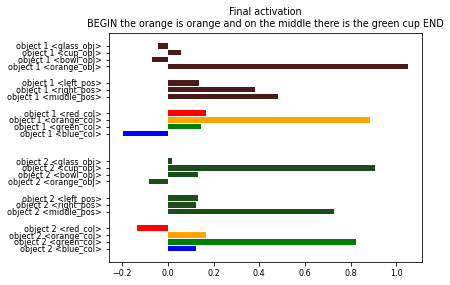

In [34]:
if not(minimal_mode):
        ##Qualitative testing

        #sample sentences for model analysis
        test_sent = ["BEGIN on the middle is a green glass and that is a orange bowl END", #0
        "BEGIN and on the middle is a green glass and that is a orange bowl END",
        "BEGIN a blue bowl is on the right and on the right there is the blue bowl END",
        "BEGIN on the middle there is the orange and the orange on the middle is orange END", #3
        "BEGIN the orange is orange and on the middle there is the green cup END",
        "BEGIN on the left there is a blue glass and this is a orange END",
        "BEGIN the glass on the left is blue and the bowl on the right is green END", #6
        "BEGIN the orange on the right is green and there is a blue cup on the middle END",
        "BEGIN on the right there is a red glass and the cup on the middle is red END",
        "BEGIN a green glass is on the right and on the left is a orange END"] #9


        outputs, vision = test_with_sentences_ESN(test_sent, reservoir, nb_concepts, threshold_factor)

        #plot final outputs on the first test sentence
        id = 4
        plot_final_activation(outputs[id][-1], concepts_delimitations, output_id_to_concept_dict, nb_concepts, test_sent[id])


        #plot and save to png the evolution of the outputs during the processing of the first test sentence (plots developped by Alexis Juven)


        id = 4
        s = test_sent[id]

        if continuous_sentence_training:
            output_fun = lambda x: x
        else:
            output_fun = sigmoid #sigmoid function is recommended when dealing with final learning

        plot_concept_activation(s,
                                outputs[id],
                                concepts_delimitations,
                                nb_concepts,
                                savefig = True,
                                sub_ttl_fig = s+ " ESN CL",
                                output_function = output_fun)

        '''
        ##reservoir activity visualisation
        res_states, vis = test_with_sentences_ESN(test_sentences, reservoir, nb_concepts, 1)
        s = test_sentences[500]

        res_act , _ = get_int_states(reservoir, [s], one_chunck = False) #get reservoir states

        plot_hidden_state_activation(s,
                                    [res_act[0]],
                                    state='reservoir',
                                    units_to_plot = [i for i in range(20)], #plot the activation of the 20 first reseroir units (arbitrary choice)
                                    plot_variation = False,
                                    plot_sum = False)
        '''

In [96]:
## create the ESN
nb_unique_words = len(word2one_hot_id)
iss = 1
nb_features = nb_unique_words
set_seed(None) #we test on a different and random seed each time

if continuous_sentence_training: # Alexis Juven's hyper-parameters optimized through random search
    sr = 1.3
    sparsity = 0.81
    leak = 0.04
    alpha_coef = 10.**(-3.7)
else:
    sr = 1.1
    sparsity = 0.85
    leak = 0.05
    alpha_coef = 10.**(-3.5)



# build an ESN online, i.e. trained with FORCE learning after each sample

W = mat_gen.fast_spectral_initialization(N, spectral_radius=sr, proba = sparsity) #reservoir matrix
Win = mat_gen.generate_input_weights(nbr_neuron=N, dim_input=nb_features, #input matrix
                                    input_bias=True, input_scaling=iss)
Wout = np.zeros((output_size, N+1)) #output matrix to be optimized


reservoir = ESNOnline(lr = leak,
                    W = W,
                    Win = Win,
                    Wout = Wout,
                    alpha_coef = alpha_coef)

In [97]:
if __name__ == "__main__":

    if use_save:
        Wout = np.load(pth+"Wout"+name_id+".npy", allow_pickle = True)
        Win = np.load(pth+"Win"+name_id+".npy", allow_pickle = True)
        W = np.load(pth+"W"+name_id+".npy", allow_pickle = True)
        W = W.item()
        reservoir = ESNOnline(lr = leak,
                            W = W,
                            Win = Win,
                            Wout = Wout,
                            alpha_coef = alpha_coef)

    if not(use_save):
        t1 = time.process_time()

        for sent_nb in range(len(trainX)): #training sentences

            if continuous_sentence_training:
                wash_init_steps = 0 #we train at each step
            else:
                wash_init_steps = trainX[sent_nb].shape[0]-1 #we train only the last step


            reservoir.reset_reservoir()
            reservoir.train(inputs=np.array([trainX[sent_nb]]),
                            teachers=np.array([[trainY[sent_nb]]*trainX[sent_nb].shape[0]]), #the teacher is always the same vector
                            wash_nr_time_step=wash_init_steps,
                            verbose=False)


            if sent_nb%100 == 0 and verbose_training:
                print("Advancement :")
                print( sent_nb/len(trainX))


        t2 = time.process_time()
        if verbose_training:
            print("CPU Time to train : ", t2 - t1, " s")

        ##saving
        if not(minimal_mode):
            print("Saving the matrices ...")
            rd_id = np.random.random()
            print("ID for file saved : "+ str(rd_id))
            np.save(r"saved_ESN/Wout"+str(rd_id), Wout)
            np.save(r"saved_ESN/Win"+str(rd_id), Win)
            np.save(r"saved_ESN/W"+str(rd_id), W)
            print("Matrices saved !")

        ##Testing
        if verbose_training:
            print("Testing on test set...")
        vtest, extest, rmsetest = test_on_test_set(reservoir, test_sentences, testX, testY, verbose_training, threshold_factor, True)

        if minimal_mode:
            print(str(nb_objects) + "," +str(vtest) + "," + str(extest) + ","+ str(rmsetest) + "," + str(t2-t1))

        if not(minimal_mode):
            print("Testing on train set...") #to compare for overfitting estimation
            vtr, extr, rmsetr = test_on_test_set(reservoir, train_sentences, trainX, trainY, True, threshold_factor, True)

Advancement :
0.0
Advancement :
0.1
Advancement :
0.2
Advancement :
0.3
Advancement :
0.4
Advancement :
0.5
Advancement :
0.6
Advancement :
0.7
Advancement :
0.8
Advancement :
0.9
CPU Time to train :  151.40297259300132  s
Saving the matrices ...
ID for file saved : 0.3756041369113501
Matrices saved !
Testing on test set...
End of testing
Valid representations :  77 / 1000
Exact representations :  58 / 1000
Testing on train set...
End of testing
Valid representations :  562 / 1000
Exact representations :  504 / 1000


In [81]:
if not(minimal_mode):
        ##Qualitative testing

        #sample sentences for model analysis
        test_sent = ["BEGIN on the middle is a green glass and that is a orange bowl END", #0
        "BEGIN and on the middle is a green glass and that is a orange bowl END",
        "BEGIN a blue bowl is on the right and on the right there is the blue bowl END",
        "BEGIN on the middle there is the orange and the orange on the middle is orange END", #3
        "BEGIN the orange is orange and on the middle there is the green cup END",
        "BEGIN on the left there is a blue glass and this is a orange END",
        "BEGIN the glass on the left is blue and the bowl on the right is green END", #6
        "BEGIN the orange on the right is green and there is a blue cup on the middle END",
        "BEGIN on the right there is a red glass and the cup on the middle is red END",
        "BEGIN a green glass is on the right and on the left is a orange END"] #9


        outputs, vision = test_with_sentences_ESN(test_sent, reservoir, nb_concepts, threshold_factor)

        #plot final outputs on the first test sentence
        id = 0
        plot_final_activation(outputs[id][-1], concepts_delimitations, output_id_to_concept_dict, nb_concepts, test_sent[id])


        #plot and save to png the evolution of the outputs during the processing of the first test sentence (plots developped by Alexis Juven)


        id = 0
        s = test_sent[id]

        if continuous_sentence_training:
            output_fun = lambda x: x
        else:
            output_fun = sigmoid #sigmoid function is recommended when dealing with final learning

        plot_concept_activation(s,
                                outputs[id],
                                concepts_delimitations,
                                nb_concepts,
                                savefig = True,
                                sub_ttl_fig = s+ " ESN",
                                output_function = output_fun)


        ##reservoir activity visualisation
        res_states, vis = test_with_sentences_ESN(test_sentences, reservoir, nb_concepts, 1)
        s = test_sentences[500]

        res_act , _ = get_int_states(reservoir, [s], one_chunck = False) #get reservoir states

        plot_hidden_state_activation(s,
                                    [res_act[0]],
                                    state='reservoir',
                                    units_to_plot = [i for i in range(20)], #plot the activation of the 20 first reseroir units (arbitrary choice)
                                    plot_variation = False,
                                    plot_sum = False)

AssertionError: With bias, Win matrix should be of shape (1000, 769) but is (1000, 57).

In [33]:
def plot_concept_activation(sentence, activations, concepts_delim,nb_concepts, output_function = None, savefig=False, sub_ttl_fig='', ylims=(-0.4, 1.4)):
    """
        Plots activation through time of the different concepts while hearing
        the sentence. If output_function is not None, it is applied to the reservoir
        output vector before plotting.
        This is a reuse of a function developped by Alexis Juven.
    """

    outputs = activations.copy()
    activation_threshold = 0.5

    if output_function is not None:

        activation_threshold = output_function(activation_threshold)

        for i in range(outputs.shape[0]):
            outputs[i, :] = output_function(outputs[i, :])


    words = sentence.split(" ")
    max_nb_seen_objects = 2
    nb_object_properties = 3

    fig, axes = plt.subplots(nb_object_properties, max_nb_seen_objects, figsize=(25,20))


    concept_delimitations = [t[0] for t in concepts_delim] + [concepts_delim[-1][1]]

    for i in range(max_nb_seen_objects):

        offset = i * nb_concepts

        axes[0, i].set_title("Object " + str(i+1), fontsize = 26)

        for j in range(nb_object_properties):

            ax = axes[j, i]
            ax.plot(outputs[:, offset + concept_delimitations[j] : offset + concept_delimitations[j+1]], linewidth = 4)
            ax.legend(param.CONCEPT_LISTS[j], loc = 2, fontsize = 26)

            ax.set_yticks([0., 0.5, 1.])
            ax.set_yticklabels([0., 0.5, 1.], fontsize = 24)

            ax.set_ylim([ylims[0], ylims[1]])

            ax.set_xticks(np.arange(len(words)))
            ax.set_xticklabels(words, fontsize = 26)
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize = 28)

            ax.plot(len(words) * [activation_threshold], '--', color = 'grey', linewidth = 3)

    fig.suptitle(sentence, fontsize = 28)
    plt.subplots_adjust(hspace = 0.3)

    if savefig:
        plt.savefig('sentence_'+sub_ttl_fig+".png", bbox_inches='tight')
        plt.close()
    else:
        fig.show()
        #plt.show()